In [1]:
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import torch.utils
import torch.utils.data

import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset
import random


# TFT
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
from pytorch_forecasting.metrics import RMSE, MAE, SMAPE, PoissonLoss, QuantileLoss
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor


In [2]:

lookback = 20
dir = '../data/PandasData/Sampled/'
ds = MyDataset(lookback=lookback)
train_batch_size = 4
test_batch_size = 16

def process_data(df_dir : str, target_freq : int = 10):
    df: pd.DataFrame = pd.read_pickle(df_dir)
    df.dropna(inplace=True, how='any')
    f_per_sec = df.groupby('TimestampID').count().mean().mean()
    if f_per_sec < target_freq:
        raise ValueError('The frequency of the data is lower than the target frequency')
    elif int(f_per_sec) == target_freq:
        pass
    else:
        resample_ratio = int(f_per_sec/target_freq)
        df = df.iloc[::resample_ratio, :]
    # # for origin
    for drop_column in ['Confidence', 
                          'Timestamp', 'TimestampID', 
                          'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 
                          'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 
                          'EyeTarget']:
        df = df.drop(columns=[drop_column], errors='ignore')

    target_columns = ['User_X', 'User_Y']
    # Reorder columns
    new_columns = target_columns + [col for col in df.columns if col not in target_columns]
    df = df[new_columns]

    return df

for file in os.listdir(dir):
    if file.endswith('.pkl'):
        df = process_data(dir+file)
        ds.read_data(df)
        
dataframes = ds.dataset

### format the data

In [3]:
for i, df in enumerate(dataframes):
    df['time_idx'] = range(len(df))
    df['series_id'] = i 

random.shuffle(dataframes)
print(f"Trajectories: {len(dataframes)}")
all_trajectories = len(dataframes)
# Concatenate all dataframes into one
full_df = pd.concat(dataframes).reset_index(drop=True)

Trajectories: 368


In [4]:
# normalize the data

mean_ = full_df.mean()
std_ = full_df.std()

for column in full_df.columns:
    if column in ['series_id', 'time_idx', 'Gazing_station', 'closest_station']:
        continue
    full_df[column] = (full_df[column] - full_df[column].mean()) / full_df[column].std()

min_ = full_df.min()
max_ = full_df.max()

for column in full_df.columns:
    if column in ['series_id', 'time_idx', 'Gazing_station', 'closest_station']:
        continue
    full_df[column] = (full_df[column] - full_df[column].min()) / (full_df[column].max() - full_df[column].min())


normalize_dict = {'mean': mean_, 'std': std_, 'min': min_, 'max': max_}


# def revert function
def revert_normalize(df):
    global normalize_dict
    for column in df.columns:
        if column in ['series_id', 'time_idx', 'Gazing_station', 'closest_station']:
            continue
        df[column] = df[column] * (normalize_dict['max'][column] - normalize_dict['min'][column]) + normalize_dict['min'][column]
        df[column] = df[column] * normalize_dict['std'][column] + normalize_dict['mean'][column]
    return df

In [100]:
from pytorch_forecasting import TimeSeriesDataSet

max_encoder_length = 32
max_prediction_length = 20
frac = 0.8
target = ['User_X', 'User_Y']


time_varying_known_reals=['AGV_speed_X', 'AGV_speed_Y', 'AGV_speed', 
   'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
   'start_station_X', 'start_station_Y', 'end_station_X', 'end_station_Y',
   'AGV_X', 'AGV_Y', 'rolling_avg'
   ]

time_varying_unknown_reals=['AGV_distance_X', 'AGV_distance_Y', 
    'User_speed_X', 'User_speed_Y', 'distance_to_closest_station',
    'distance_to_closest_station_X', 'distance_to_closest_station_Y',
    'distance_from_start_station_X', 'distance_from_start_station_Y',
    'distance_from_end_station_X', 'distance_from_end_station_Y', 
    'GazeDirection_X', 'GazeDirection_Y', 'GazeDirection_Z', 
    'Gazing_station', 'closest_station', 'User_X', 'User_Y'
    ]

training = TimeSeriesDataSet(
    full_df[lambda x: x.series_id <= all_trajectories * frac],  # Adjust based on your timeline
    time_idx="time_idx",
    target=target,
    group_ids=["series_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals= time_varying_known_reals,
    time_varying_unknown_reals= time_varying_unknown_reals,
    scalers={}  # Disables automatic scaling
)

validation = TimeSeriesDataSet(
    full_df[lambda x: x.series_id > all_trajectories * frac],  # Adjust based on your timeline
    time_idx="time_idx",
    target=target,
    group_ids=["series_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals= time_varying_known_reals,
    time_varying_unknown_reals= time_varying_unknown_reals,
    predict_mode=True,
    scalers={}  # Disables automatic scaling
)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16  # Adjust based on your GPU capacity
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2, drop_last=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2, drop_last=True)

print("Train dataset length: ", len(training))
print("Validation dataset length: ", len(validation))

Train dataset length:  63694
Validation dataset length:  73


In [ ]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=[1,1], 
    loss=nn.MSELoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(max_epochs=20, 
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("../model/TFT_logs"), 
)

/home/shaoze/anaconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaoze/anaconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 512   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 41.2 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 15.3 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Testing

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
# best_model_path =  "/home/shaoze/Documents/Boeing/Boeing-Trajectory-Prediction/model/TFT_logs/lightning_logs/version_3/checkpoints/epoch=3-step=15920.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(best_model_path)

../model/TFT_logs/lightning_logs/version_9/checkpoints/epoch=1-step=7960.ckpt


/home/shaoze/anaconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaoze/anaconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
validation_result = trainer.validate(best_tft, val_dataloader)
# # calcualte mean absolute error on validation set
# predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
# MAE()(predictions.output, predictions.y)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      User_X val_MAE       │   0.003286717226728797    │
│      User_X val_MAPE      │   0.017628781497478485    │
│      User_X val_RMSE      │   0.004608692601323128    │
│     User_X val_SMAPE      │   0.018403448164463043    │
│      User_Y val_MAE       │    0.00799680408090353    │
│      User_Y val_MAPE      │   0.039752405136823654    │
│      User_Y val_RMSE      │   0.010659046471118927    │
│     User_Y val_SMAPE      │    0.03838849440217018    │
│         val_loss          │  0.00013825630594510585   │
└───────────────────────────┴───────────────────────────┘

### Visualization

In [ ]:
predictions = []
truths = []
inputs = []

# Check if 'User_X' and 'User_Y' are in the continuous features list and get their indices
user_x_index = training.reals.index("User_X") if "User_X" in training.reals else None
user_y_index = training.reals.index("User_Y") if "User_Y" in training.reals else None


with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        x, y = batch
        y_hat = best_tft(x)
        User_x, User_y = y[0][0], y[0][1]
        y = torch.cat([User_x.unsqueeze(-1), User_y.unsqueeze(-1)], dim=-1)
        User_x_pred, User_y_pred = y_hat.prediction[0], y_hat.prediction[1]
        pred = torch.cat([User_x_pred, User_y_pred], dim=-1)
        predictions.append(pred)
        truths.append(y)
        inputs.append(x['encoder_cont'][:,:,user_x_index:user_y_index+1])

# Concatenate all collected predictions and truths
predictions = torch.cat(predictions, dim=0)
truths = torch.cat(truths, dim=0)
inputs = torch.cat(inputs, dim=0)

In [ ]:
# revert normalize

for idx, key_ in enumerate(["User_X", "User_Y"]):
    predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    inputs[:, :, idx] = inputs[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    inputs[:, :, idx] = inputs[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    

/home/shaoze/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shaoze/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shaoze/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/shaoze/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-

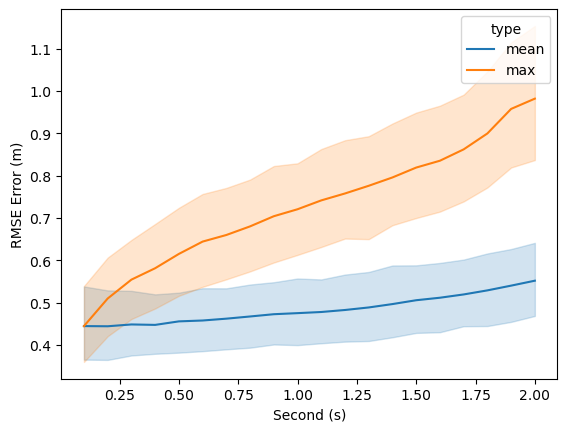

In [ ]:
criterion = nn.MSELoss(reduction="none")

steps = []
loss = []
max_loss = []
for step in range(1, 21):
    raw_rmse_loss = criterion(predictions[:, :step, :], truths[:, :step, :])
    raw_rmse_loss = torch.sqrt(torch.sum(raw_rmse_loss, dim=-1))
    mean_rmse_loss = raw_rmse_loss.mean(dim=-1)
    max_rmse_loss = raw_rmse_loss.max(dim=-1).values
    loss.append(mean_rmse_loss)
    max_loss.append(max_rmse_loss)
    steps.extend([step] * len(mean_rmse_loss))
    
max_loss = torch.cat(max_loss).numpy()
loss = torch.cat(loss).numpy()

df = pd.DataFrame({'Second (s)': steps, 'loss': loss})
df1 = pd.DataFrame({'Second (s)': steps, 'loss': max_loss})
df['type'] = 'mean'
df1['type'] = 'max'
df = pd.concat([df, df1])


df['RMSE Error (m)'] = df['loss'] / 100 # to meters
df['Second (s)'] = df['Second (s)'] / 10 # to seconds
sns.lineplot(data = df, x='Second (s)', y='RMSE Error (m)', hue='type')
plt.savefig('../figure/TFT_RMSE.png')
plt.show()